In [8]:
#%run matplotlib_setup.ipy

from types import SimpleNamespace

from ipywidgets import interact
import matplotlib
from matplotlib import pyplot
from mpl_toolkits import mplot3d
import numpy as np
import scipy.linalg as la 
from math import floor
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
import kwant
from kwant.wraparound import wraparound, plot_2d_bands

Zigzag = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,np.sqrt(3)/2],[4/6,np.sqrt(3)/2],[5/6,0]]) # Coordinates

a,b,c,d = Zigzag.sublattices


def get_width(N=7): 
    if N < 2: 
        raise("N cannot be less than 2")
    else:
        return N/2*Zigzag.prim_vecs[1][1] + 0.01
    
def get_length(L=8): 
    return L/4*Zigzag.prim_vecs[0][0]
    
def make_1D_zigzag(N=7,L=8):
    #syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag.prim_vecs[0]))
    #syst = kwant.Builder(kwant.TranslationalSymmetry([get_length(L),0]))
    syst = kwant.Builder()
    syst[Zigzag.shape((lambda pos: pos[1] >0 and pos[1] <= get_width(N) and 0 <= pos[0] < get_length(L)),(0,0))] = 0
    syst[Zigzag.neighbors()] = -1
    return syst

def terminate_edges(syst): 
    sites = list(syst.sites())
    #print(sites)
    nsites = len(sites)
    pos = np.array([site.pos for site in sites])
    tags = [site.tag for site in sites]
    family = [site.family for site in sites]
    ymax = np.max(pos[:,1])
    ymin = np.min(pos[:,1])
    edge_index = []
    for i,p in enumerate(pos): 
        if abs(p[1] - ymax) < 1.e-2 or abs(p[1]-ymin) < 1.e-2: 
            edge_index.append(i)
    nedges = len(edge_index)
    #print(edge_index)
    edge_hoping_pairs = []
    for i in range(nedges): 
        site1 = sites[edge_index[i]]
        #print(site1.pos)
        neigh_sites = syst.neighbors(site1)
        for site2 in neigh_sites: 
            if abs(site2.pos[1] - ymax) < 1.0e-2  or abs(site2.pos[1]-ymin)< 1.0e-2:
                hop_pair = [site1.tag,site2.tag]
                pair_seen = hop_pair in edge_hoping_pairs
                if not pair_seen:
                    syst[site1,site2] = -1 - 0.5
                    edge_hoping_pairs.append([site1.tag,site2.tag])
                    #print(site1.pos)
                    #print(site2.pos)
    #print(edge_hoping_pairs)
    #print(edge_index)           
    return syst

def finite_to_1D(system,lat_vec,trans_sym_direction='x'): 
    """Adds a translational symmetry on a finite system
    Useful for making complex geometries eg: cove-edged and chevron ribbon
    
    Parameters
    ==========
        system: instance of the finite system
        lat_vec: lattice vector of the translational symmetry 
        trans_sym_direction: 'x' or 'y' , direction of the translational symmetry
        
    TODO: 
    1. Currently only works for orthorhombic unit cells 
    2. Get the onsite and hopping values directly from the passed system
        Currently hard set inside the code"""
    
    sites = list(system.sites())
    pos = [site.pos for site in sites] 
    if trans_sym_direction=='x':
        a = lat_vec
        b = max(np.array(pos)[:,1])
        trans_vec=[a,0]
    elif trans_sym_direction=='y':
        a = max(np.array(pos)[:,0])
        b = lat_vec
        trans_vec=[0,b]
    else: 
        raise #"Translation Symmetry direction should be 'x' or 'y'"
    lattice_1D = kwant.lattice.general([[a,0],[0,b]],pos)
    system_1D = kwant.Builder(kwant.TranslationalSymmetry(trans_vec))
    if trans_sym_direction=='x':
        system_1D[lattice_1D.shape((lambda pos: 0< pos[1] <= b),(0,0))]=0 
    if trans_sym_direction=='y':
        system_1D[lattice_1D.shape((lambda pos: 0< pos[0] <= a),(0,0))]=0 
    system_1D[lattice_1D.neighbors(2)] = -1
    return system_1D 

def get_pol_custom(syst):
    pos = [ site.pos for  site in syst.sites()]
    nsites = len(pos)
    syst = syst.finalized()
    kwant.plotter.bands(syst)
    lattice = kwant.lattice.general([[get_length(4),0],[0,get_width(16)]],pos)
    act_pos = np.array([syst.pos(i) for i in range(nsites)])
    a1,a2 = [lattice.prim_vecs[0][0],get_width(N=7)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(syst,momenta=1001,dim=2)
    z2_system = z2pack.hm.System(ham_k,dim=2,#pos=red_pos,
                                     convention=1)
    result = z2pack.line.run(system=z2_system, 
                            line=lambda t1: [t1,0])#,#,n/(N+1)])#,
                            #pos_tol=1e-3,iterator=range(200,500,2));

    print("Polarization:",result.pol)
    
def make_junction(syst1,syst2,lx1,lx2,ly,xoff=0,yoff=0):
    lx = lx1 + lx2
    nx = 7
    nx1 = nx 
    nx2 = nx
    pos_all0 = []
    #pos1 =  [[site.pos[0],site.pos[1]] for site in syst1.sites()]
    #pos2 =  [[site.pos[0],site.pos[1]] for site in syst2.sites()]
    for i in range(nx1):
        pos1 =  [[site.pos[0] + i*lx1,site.pos[1]] for site in syst1.sites()]
        pos_all0 += pos1
    for i in range(nx2): 
        pos2 =  [[site.pos[0] + nx1*lx1 + i*lx2+xoff,site.pos[1]+yoff] for site in syst2.sites()]
        pos_all0 += pos2
    pos_all = pos_all0
    #pos_all = []
    #for item in pos_all0:
    #    if item not in pos_all: 
    #        pos_all.append(item)
        #print(item)

    min_y = np.min(np.array(pos_all)[:,1])
    lat = kwant.lattice.general([[nx*lx+6,0],[0,2*ly]],pos_all,norbs=1)
    #syst = kwant.Builder(kwant.TranslationalSymmetry([lx,0]))
    syst = kwant.Builder()
    syst[lat.shape((lambda pos: 0< pos[0]< nx*lx+xoff+2 and min_y - yoff<=pos[1]<ly+yoff),(0,0))] = 0 
    syst[lat.neighbors()] = -1 
    print(len(pos1),len(pos2),len(pos_all))
    return syst 

def plot_wf(syst,i_start,i_end,ham):
    """Plot the wave function mapping on system with Hamiltonian 
    "ham" in a PyWidget starting from band index i_start and 
    ending at i_end"""
    eig_val,eig_vec = la.eigh(ham)
    def plot_band(i=0): 
        print("Plotting wave function with index",i)
        print("Energy of the corresponding mode",eig_val[i], "x t")
        fig = kwant.plotter.map(syst,abs(eig_vec[:,i])**2,oversampling=3,fig_size=(16,10))
        
        #fig.savefig('figures/%s.jpg'%i,dpi=400,quality=100,transparent=True)
    
    interact(plot_band,i=(i_start,i_end))
    
def check_junction(syst1,syst2,lx1,lx2,ly=14,xoff=0,yoff=0):
    syst = make_junction(syst1,syst2,lx1,lx2,ly,xoff,yoff)
    #syst.eradicate_dangling()
    kwant.plot(syst,site_color='black',fig_size=(16,10));
    
    nbands = len(syst.sites())
    n1 = int(nbands/2 -5)
    n2 = int(nbands/2 +5)
    print('Number of bands in junction is {}'.format(nbands))
    
    syst = syst.finalized()
    ham = syst.hamiltonian_submatrix() 
    fig = plot_wf(syst,n1,n2,ham)

# Non-Trivial bent unit cell

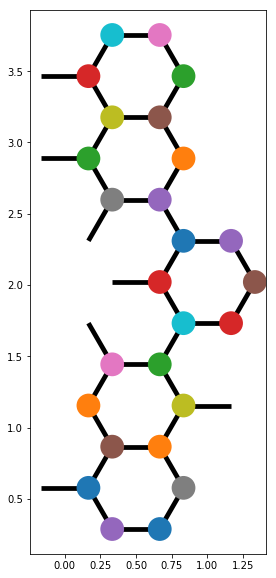

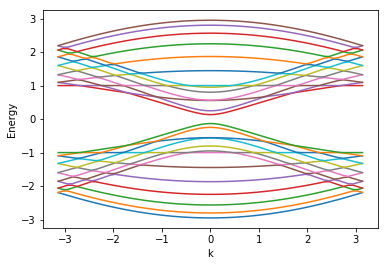


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-07-09 14:44:03,333                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x1039dd950>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [7]:
temp = make_1D_zigzag(N=13,L=6)
temp = terminate_edges(temp)
#kwant.plot(temp,fig_size=(16,10));
sites = [site for site in temp.sites()]
for site in sites: 
    if 1.6 < site.pos[1] < 2.5 and site.pos[0]<0.4:
        del temp[site]
    if site.pos[0] > 1.0 and site.pos[1] < 1.5:
         del temp[site]
    if site.pos[0] > 1.0 and site.pos[1] > 2.5:
         del temp[site]

nt_right = temp    
nt_right = finite_to_1D(temp,get_length(4),trans_sym_direction='x')
kwant.plot(nt_right,fig_size=(16,10));
get_pol_custom(nt_right)

# Non-trivial bent unit cell

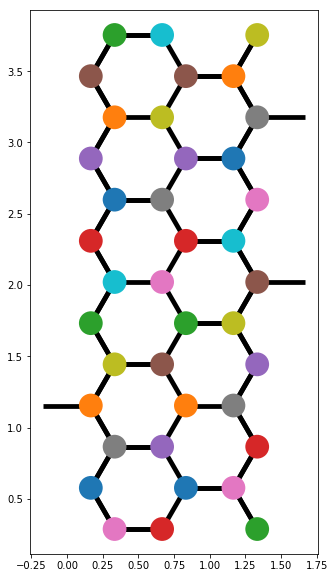

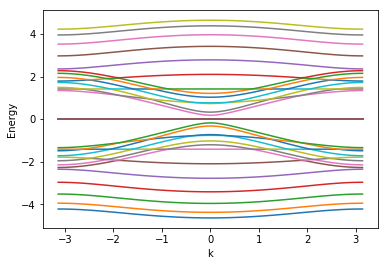


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-07-09 11:16:46,709                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x121b6e510>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [9]:
temp = make_1D_zigzag(N=13,L=6)
sites = [site for site in temp.sites()]
temp = terminate_edges(temp)
# for site in sites: 
#     if 0.5 < site.pos[1] < 1.2 and site.pos[0]<0.4:
#         del temp[site]
#     if site.pos[0] > 1.0 and site.pos[1] > 1.2:
#         del temp[site]
#     if 0.5 > site.pos[1] and site.pos[0] > 1.0:
#         del temp[site]
#kwant.plot(temp,fig_size=(16,10));
#sites = [site for site in temp.sites()]
#for site in sites: 
#    if 1.73 < site.pos[1] < 1.77 and site.pos[0]<0.25:
#        del temp[site]
#    elif site.pos[1] > 1.77 and site.pos[0] < 1.0:
#        del temp[site]
#    elif 1.5 > site.pos[1] and site.pos[0] > 1.0:
#        del temp[site]
#    elif site.pos[0] > 1.75:
#       try: 
#            del temp[site]
#        except: 
#            continue
#         if site.pos[1]/(site.pos[0]-get_length(7)) < np.tan(np.pi/3):
#             del temp[site]
#     if 1.0 <site.pos[0]< 1.2: 
#         if site.pos[1] < 0.5:      
#             del temp[site]
#     if 1.8<site.pos[0]<2.2 or site.pos[0]>3.0: 
#         if site.pos[1] > 2.2:
#             del temp[site]

nontrivial = temp
nontrivial = finite_to_1D(temp,get_length(4),trans_sym_direction='x')
kwant.plot(nontrivial,fig_size=(16,10));
get_pol_custom(nontrivial)

26 18 616


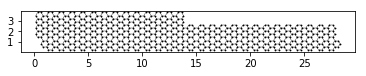

Number of bands in junction is 614


interactive(children=(IntSlider(value=302, description='i', max=312, min=302), Output()), _dom_classes=('widge…

In [20]:
check_junction(nontrivial,trivial,lx1=1,lx2=1)

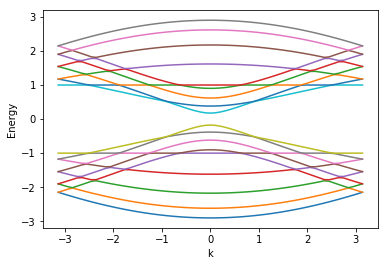


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-06-27 13:06:39,777                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x1197407b8>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

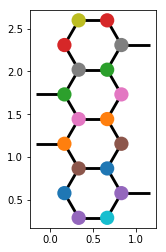

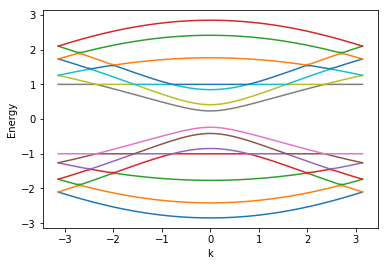


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-06-27 13:06:40,107                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x119c40620>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

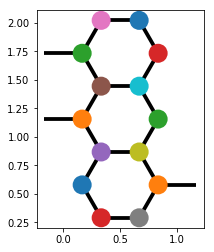

In [15]:
temp = make_1D_zigzag(N=9,L=4)
Z9 = temp 
Z9 = finite_to_1D(Z9,get_length(4),trans_sym_direction='x');
get_pol_custom(Z9)
kwant.plot(Z9);

temp = make_1D_zigzag(N=7,L=4)
Z7 = temp 
Z7 = finite_to_1D(Z7,get_length(4),trans_sym_direction='x');
get_pol_custom(Z7)
kwant.plot(Z7);

In [12]:
Zigzag_dash = kwant.lattice.general([[1,0],[0,np.sqrt(3)/3]], #Lattice vectors
                                     [[1/6,0],[2/6,-np.sqrt(3)/2],[4/6,-np.sqrt(3)/2],[5/6,0]]) # Coordinates

def get_width_dash(N=7): 
    #if N < 2: 
        #raise("N cannot be less than 2")
    #else:
    return N/2*Zigzag_dash.prim_vecs[1][1]

def make_1D_zigzag_dash(N=7):
    syst = kwant.Builder(kwant.TranslationalSymmetry(Zigzag_dash.prim_vecs[0]))
    syst[Zigzag_dash.shape((lambda pos: pos[1] >-1*get_width_dash(1) and pos[1] <= get_width_dash(N-1)),(0,0))] = 0
    syst[Zigzag_dash.neighbors()] = -1
    return syst

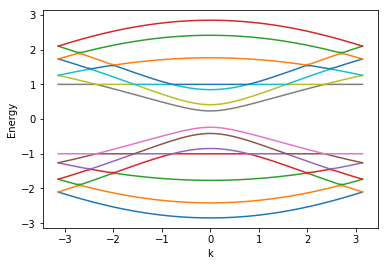


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-06-27 12:56:38,654                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x11a412268>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

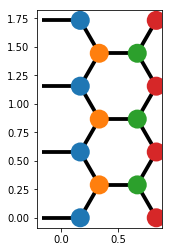

In [13]:
Z7_dash = make_1D_zigzag_dash(N=7)
get_pol_custom(Z7_dash)
kwant.plot(Z7_dash);

18 14 256


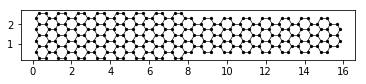

Number of bands in junction is 254


interactive(children=(IntSlider(value=122, description='i', max=132, min=122), Output()), _dom_classes=('widge…

In [14]:
check_junction(Z9,Z7_dash,lx1=1,lx2=1,yoff=np.sqrt(3)/3)

18 14 256


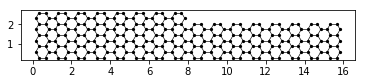

Number of bands in junction is 256


interactive(children=(IntSlider(value=123, description='i', max=133, min=123), Output()), _dom_classes=('widge…

In [16]:
check_junction(Z9,Z7,lx1=1,lx2=1,yoff=0.0)

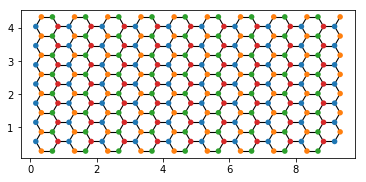

Number of bands in junction is 284


interactive(children=(IntSlider(value=137, description='i', max=147, min=137), Output()), _dom_classes=('widge…

In [29]:
temp = make_1D_zigzag(N=15,L=40)
sites = [site for site in temp.sites()]
for site in sites: 
    if  site.pos[0] > 9.4:
        del temp[site]
    if site.pos[1] < 0.5 and site.pos[0] > 9.2:
        try: 
            del temp[site]
        except: 
            continue
    #if site.pos[1] > 2.0 and site.pos[0] > 9.1:
    #    try: 
    #        del temp[site]
    #    except: 
    #        continue
    #if 0.5 > site.pos[1] and site.pos[0] > 1.0:
    #    del temp[site]
kwant.plot(temp)
nbands = len(temp.sites())
n1 = int(nbands/2 -5)
n2 = int(nbands/2 +5)
print('Number of bands in junction is {}'.format(nbands))
temp = temp.finalized()
ham = temp.hamiltonian_submatrix()
plot_wf(temp,n1,n2,ham)

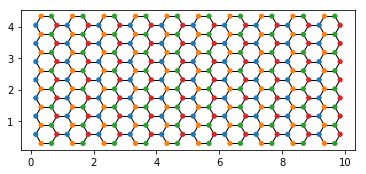

Number of bands in junction is 300


interactive(children=(IntSlider(value=145, description='i', max=155, min=145), Output()), _dom_classes=('widge…

In [30]:
temp = make_1D_zigzag(N=15,L=40)
kwant.plot(temp)
nbands = len(temp.sites())
n1 = int(nbands/2 -5)
n2 = int(nbands/2 +5)
print('Number of bands in junction is {}'.format(nbands))
temp = temp.finalized()
ham = temp.hamiltonian_submatrix()
plot_wf(temp,n1,n2,ham)

## Hole/Junction

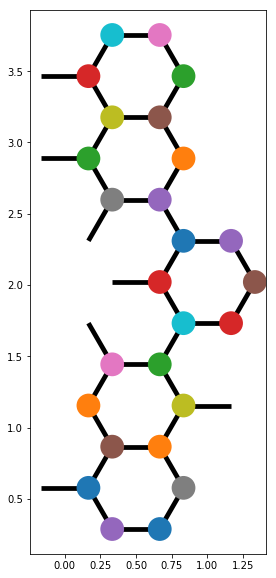

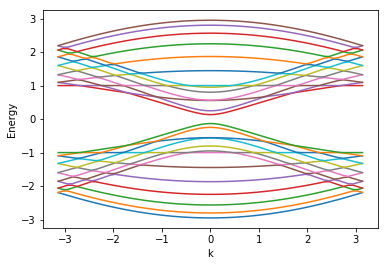


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-07-09 14:51:40,789                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x114927840>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [10]:
temp = make_1D_zigzag(N=13,L=6)
temp = terminate_edges(temp)
#kwant.plot(temp,fig_size=(16,10));
sites = [site for site in temp.sites()]
for site in sites: 
    if 1.6 < site.pos[1] < 2.5 and site.pos[0]<0.4:
        del temp[site]
    if site.pos[0] > 1.0 and site.pos[1] < 1.5:
         del temp[site]
    if site.pos[0] > 1.0 and site.pos[1] > 2.5:
         del temp[site]
#     if 0.5 > site.pos[1] and site.pos[0] > 1.0:
#         del temp[site]
#     if 0.5 < site.pos[1] and site.pos[0] > 1.2:
#         try: 
#             del temp[site]
#         except: 
#             continue
#    elif site.pos[0] > 1.75:
#        try: 
#            del temp[site]
#        except: 
#            continue
#         if site.pos[1]/(site.pos[0]-get_length(7)) < np.tan(np.pi/3):
#             del temp[site]
#     if 1.0 <site.pos[0]< 1.2: 
#         if site.pos[1] < 0.5:      
#             del temp[site]
#     if 1.8<site.pos[0]<2.2 or site.pos[0]>3.0: 
#         if site.pos[1] > 2.2:
#             del temp[site]
 
trivial = temp    
trivial = finite_to_1D(temp,get_length(4),trans_sym_direction='x')
kwant.plot(trivial,fig_size=(16,10));
get_pol_custom(trivial)

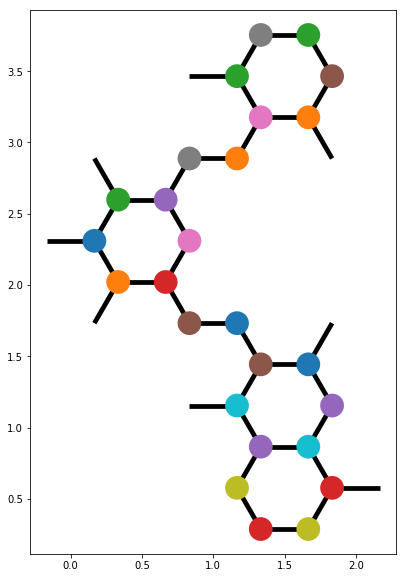

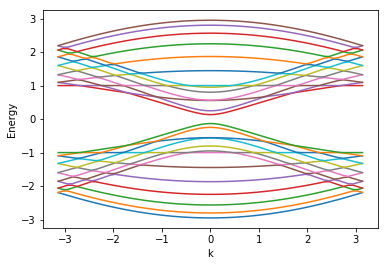


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-07-09 14:51:49,507                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x11236e598>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [11]:
temp = make_1D_zigzag(N=13,L=8)
sites = [site for site in temp.sites()]
temp = terminate_edges(temp)

for site in sites: 
    if 1.6 < site.pos[1] < 3.0 and site.pos[0]>1.5:
        del temp[site]
    if 2.0 < site.pos[1] < 2.6 and site.pos[0]>1.0:
        try:
            del temp[site]
        except: 
            continue

    if site.pos[0] < 0.5 and site.pos[1] > 2.7:
        del temp[site]
        
    if site.pos[0] < 0.6 and site.pos[1] < 1.8:
             del temp[site]
            
    if site.pos[0] < 1.0 and site.pos[1] < 1.5:
        try:
             del temp[site]
        except: 
             continue
    if site.pos[0] < 1.0 and site.pos[1] > 3.0:
        try:
             del temp[site]
        except: 
             continue
nontrivial = temp
# pos_temp = np.array([site.pos for site in temp.sites()])
# min_x = np.min(pos_temp[:,0])
# pos_temp[:,0] = pos_temp[:,0] - min_x -1/2
# nt_lat = kwant.lattice.general([[1,0],[0,get_width(13)]],pos_temp)                            
# nontrivial = kwant.Builder(kwant.TranslationalSymmetry([1,0]))
# nontrivial[nt_lat.shape((lambda pos: 0<= pos[1] <get_width(13)),(0,0))] = 0 
# nontrivial[nt_lat.neighbors(2)] = -1
nontrivial = finite_to_1D(temp,get_length(4),trans_sym_direction='x')
kwant.plot(nontrivial,fig_size=(16,10));
get_pol_custom(nontrivial)

26 26 364


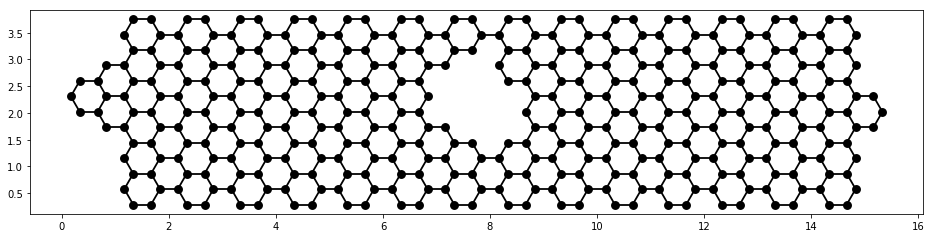

Number of bands in junction is 364


interactive(children=(IntSlider(value=177, description='i', max=187, min=177), Output()), _dom_classes=('widge…

In [12]:
check_junction(nontrivial,trivial,lx1=1,lx2=1,xoff=1)#,yoff=np.sqrt(3)/3)

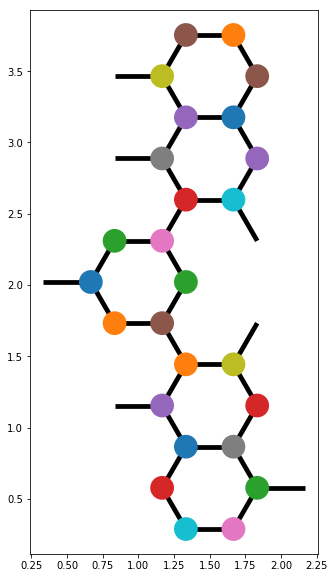

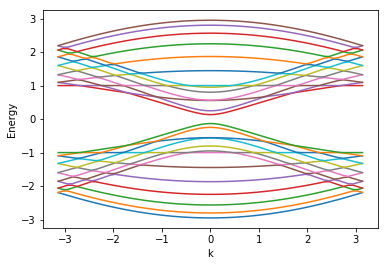


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-07-09 14:43:36,333                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x11453c598>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [6]:
temp = make_1D_zigzag(N=13,L=8)
temp = terminate_edges(temp)
#kwant.plot(temp,fig_size=(16,10));
sites = [site for site in temp.sites()]
for site in sites: 
    if 1.6 < site.pos[1] < 2.5 and site.pos[0]>1.5:
        del temp[site]
    if site.pos[0] < 1.0 and site.pos[1] < 1.5:
        del temp[site]
    if site.pos[0] < 1.0 and site.pos[1] > 2.5:
        del temp[site]
    if site.pos[0] < 0.5:
        try:
            del temp[site]
        except: 
            continue

nt_left = temp    
nt_left = finite_to_1D(temp,get_length(4),trans_sym_direction='x')
kwant.plot(nt_left,fig_size=(16,10));
get_pol_custom(nt_left)

26 26 364


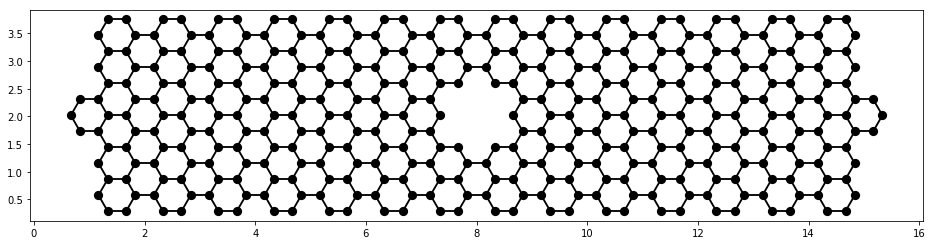

Number of bands in junction is 364


interactive(children=(IntSlider(value=177, description='i', max=187, min=177), Output()), _dom_classes=('widge…

In [13]:
check_junction(nt_left,nt_right,lx1=1,lx2=1,xoff=1)#,yoff=np.sqrt(3)/3)